# Assignment — Link Prediction & GNN

In [8]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.manifold import TSNE
import torch.nn.functional as F
from sklearn.decomposition import TruncatedSVD
import requests
from sklearn.metrics import roc_curve, auc
import networkx as nx
from torch.optim import Adam
import numpy as np
from tqdm.notebook import tqdm
import torch
from tqdm.notebook import trange
from sklearn.linear_model import LogisticRegression
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

### Task 1. Dataset for link prediction (0 points)

Consider link prediction on the [e-mails network](http://snap.stanford.edu/data/email-Eu-core-temporal.html) where nodes are members of a research institution and edges are e-mails given with timestamps. The goal is to predict occurrence of edges in the test time period using information from the train time period only.

In [9]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/email-Eu-core-temporal.txt'
open('email-Eu-core-temporal.txt', 'wb').write(requests.get(url).content);


In [10]:
email_df = pd.read_csv(
    'email-Eu-core-temporal.txt', 
    delimiter=' ', 
    names=['sender', 'receiver', 'timestamp']
)
email_df


,sender,receiver,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926
...,...,...,...
332329,324,367,45401817
332330,790,126,45402441
332331,790,126,45403709
332332,782,126,45404903


Next, consider the following preprocessing procedure:
1. Select edges by given train and test time periods, for example, [0, 1000) is train and [1000, 2000) is test
2. Build a _core_ — a connected network where every edge occurs at least $k_\text{train}$ times in the train time period or at least $k_\text{test}$ times in the test time period. Let the core be undirected, so occurrences edges (1, 0) and (0, 1) are computed together.
3. From the core, select a train set of edges $E_\text{train}$ that occur for the first time in the train period. All others are included to $E_\text{test}$.
3. Exclude test edges that contain nodes that do not occur in train edges.

Write a function `train_test_edges` that takes a pd.DataFrame `email_df` with e-mail network, a tuple with the train time period borders `train_period`, say, (0, 1000), a similar tuple `test_period`, the number of edges occurrences `ktrain` and `ktest`. The function returns two lists with tuples — train and test edges. Every edge is returned of the form where the first node is less than the second, for example [(1, 2), (2, 3)] is ok, but [(2, 1), (3, 2)] is wrong.

In [11]:
def train_test_edges(email_df, train_period, test_period, ktrain, ktest):
    
    email_temp = email_df.copy()
    email_temp = email_temp[
        (train_period[0] <= email_temp.timestamp) 
        & (email_temp.timestamp < test_period[1])
    ]
    email_temp['from'] = email_temp[['sender', 'receiver']].min(axis=1)
    email_temp['to'] = email_temp[['sender', 'receiver']].max(axis=1)
    email_temp = email_temp.drop(['sender', 'receiver'], axis=1)
    email_temp = email_temp.set_index(['from', 'to'])

    email_train = email_temp[email_temp.timestamp < train_period[1]]
    email_train = email_train.groupby(['from', 'to']).count()
    train_core = email_train[email_train.timestamp >= ktrain].index.tolist()

    email_test = email_temp[test_period[0] <= email_temp.timestamp]
    email_test = email_test.groupby(['from', 'to']).count()
    test_core = email_test[email_test.timestamp >= ktest].index.tolist()
    
    core = list(set(train_core + test_core))

    ### BEGIN SOLUTION
    email_first = email_temp.loc[core].groupby(['from', 'to']).min()

    train_edges = email_first[email_first.timestamp < train_period[1]].index.tolist()
    _test_edges = email_first[test_period[0] <= email_first.timestamp].index.tolist()
    
    train_nodes = set()
    for (u, v) in train_edges:
        train_nodes.add(u)
        train_nodes.add(v)
    test_edges = []
    for (u, v) in _test_edges:
        if u in train_nodes and v in train_nodes:
            test_edges.append((u, v))
    
    return train_edges, test_edges
    ### END SOLUTION

In [7]:
train_pos, test_pos = train_test_edges(email_df, (1e7, 2e7), (2e7, 2.5e7), 4, 2)
_train_pos, _test_pos = np.array(train_pos), np.array(test_pos)
assert np.all(_train_pos[:, 0] < _train_pos[:, 1])
assert np.all(_test_pos[:, 0] < _test_pos[:, 1])
assert len(set(train_pos).intersection(test_pos)) == 0
assert _train_pos.shape == (3880, 2)
assert _test_pos.shape == (720, 2)

NameError: ignored

### Task 2. Negative sampling (0 points)

Usually, graphs are sparse, so there is a high imbalance between existent (positive) edges and nonexistent (negative) edges. Since the link prediction can be considered as a classification problem, the imbalance leads to the high misclassification. To eliminate this problem, we can use negative sampling techniques, that is using only some random part of the negative edges in training.

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/pos_neg_edges.png' width=500>

The simplest sampling strategy is to copy positive edges and randomly replace one node checking they do not occur in positive set and they are not self-loops. Let the negative set be the same size as the positive.

The `negative_sampling` function samples the unexisted edges from the graph. It takes list of train and test positive edges and returns train and test negative edges.

In [ ]:
def negative_sampling(train_pos, test_pos):
    ### BEGIN SOLUTION
    pos_edges = train_pos + test_pos
    nodes = np.unique(pos_edges)
    neg_edges = []
    for u, v in tqdm(pos_edges):
        while True:
            neg_v = np.random.choice(nodes)
            if (u == neg_v) or ((u, neg_v) in pos_edges) or ((neg_v, u) in pos_edges):
                continue
            neg_edges.append((u, neg_v))
            break
    return neg_edges[:len(train_pos)], neg_edges[len(train_pos):]
    ### END SOLUTION

In [ ]:
train_neg, test_neg = negative_sampling(train_pos, test_pos)
neg_edges = train_neg + test_neg
pos_edges = train_pos + test_pos
assert len(train_neg) == len(train_pos)
assert len(test_neg) == len(test_neg)
# negative edges has nodes from only positive edges
assert len(set(np.unique(neg_edges)).difference(np.unique(pos_edges))) == 0
# source nodes are the same
assert np.all(np.array(pos_edges)[:, 0] == np.array(neg_edges)[:, 0])
# no edges in both
assert len(set(pos_edges) & set(neg_edges)) == 0
# reversed negative edges are not positive
reversed_neg_edges = [(v, u) for u, v in neg_edges]
assert len(set(pos_edges) & set(reversed_neg_edges)) == 0

Form train and test pairs of nodes that contain positive and negative edges:
* $X_\text{train}, X_\text{test}$ — pairs of nodes, contains positive and negative edges
* $y_\text{train}, y_\text{test}$ — labels of pairs, 1 is positive, 0 is negative

In [276]:
x_train = np.random.permutation(train_pos + train_neg)
y_train = [int((u, v) in train_pos) for (u, v) in x_train]

x_test = np.random.permutation(test_pos + test_neg)
y_test = [int((u, v) in test_pos) for (u, v) in x_test]
y_test[:10]


[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

### Task 3. Prediction by similarity score (3 points)

Similarity based algorithm predicts the existence of a link using the similarity score of a pair of nodes: $P(A_{i, j}) \propto \text{sim}(i, j)$. The algorithm builds a graph using only train positive edges, computes similarity score for all test pairs and then predicts the link existence by the threshold on ordered by similarity score pairs.

Write a function `sim_link_prediction` that takes edges and labels. The function predicts links and returns a tuple with metrics: 
* FPR (false positive rate) and TPR (true positive rate) in descending of thresholds obtained by Jaccard coefficient, `nx.jaccard_coefficient`: $$\text{sim}(i, j) = \frac{|N(i) \cap N(j)|}{|N(i) \cup N(j)|}$$
* FPR, TPR by Adamic-Adar index, `nx.adamic_adar_index`: $$\text{sim}(i, j) = \sum_{x \in N(i) \cap N(j)} \frac{1}{\log|N(x)|}$$
* FPR, TPR by resource allocation index, `nx.resource_allocation_index`: $$\text{sim}(i, j) = \sum_{x \in N(i) \cap N(j)} \frac{1}{|N(x)|}$$

_Hint: use `sklearn.metrics.roc_curve`._

In [277]:
def sim_link_prediction(train_pos, x_test, y_test):
    pos_edges = train_pos
    nodes = np.unique(pos_edges)
    graph = nx.Graph() 
    for u, v in tqdm(pos_edges):
        graph.add_edge(u, v)
    
    edges_jaccard = {} 
    edges_adamic_adar = {} 
    edges_resource_allocation = {}

    jaccard_scores = [] 
    adamic_adar_scores = []
    resource_allocation_scores = [] 


    preds_jaccard = nx.jaccard_coefficient(graph, ebunch=x_test)
    for u, v, p in preds_jaccard:
        edges_jaccard[(u, v)] = p 
        jaccard_scores.append(p)

    preds_adamic_adar = nx.adamic_adar_index(graph, ebunch=x_test)
    for u, v, p in preds_adamic_adar:
        edges_adamic_adar[(u, v)] = p 
        adamic_adar_scores.append(p)

    preds_resource_allocation = nx.resource_allocation_index(graph, ebunch=x_test)
    for u, v, p in preds_resource_allocation:
        edges_resource_allocation[(u, v)] = p 
        resource_allocation_scores.append(p)


    fpr_jaccard, tpr_jaccard, _ = roc_curve(y_test, jaccard_scores, pos_label=1)
    fpr_adamic_adar, tpr_adamic_adar, _ = roc_curve(y_test, adamic_adar_scores, pos_label=1)
    fpr_resource_allocation, tpr_resource_allocation, _ = roc_curve(y_test, resource_allocation_scores, pos_label=1)


    return (fpr_jaccard, tpr_jaccard), (fpr_adamic_adar, tpr_adamic_adar), (fpr_resource_allocation, tpr_resource_allocation)




In [10]:
jac, adam, res = sim_link_prediction(
    train_pos, 
    [[53, 500], [500, 843], [509, 969], [40, 91], [147, 28], [91, 535], [890, 15]],
    [1, 0, 1, 0, 0, 1, 0],
)
assert jac[0].shape == jac[1].shape
assert adam[0].shape == adam[1].shape
assert res[0].shape == res[1].shape
assert round(auc(jac[0], jac[1]), 4) == 0.5
assert round(auc(adam[0], adam[1]), 4) == 0.4167
assert round(auc(res[0], res[1]), 4) == 0.4167

  0%|          | 0/3880 [00:00<?, ?it/s]

Let us look at the ROC AUC curve to compare results.

  0%|          | 0/3880 [00:00<?, ?it/s]

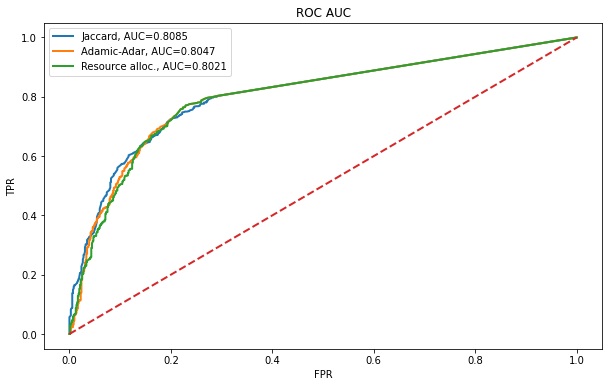

In [11]:
jac, adam, res = sim_link_prediction(train_pos, x_test, y_test)
plt.figure(figsize=(10, 6))
cases = [[jac[0], jac[1], 'Jaccard'], 
         [adam[0], adam[1], 'Adamic-Adar'], 
         [res[0], res[1], 'Resource alloc.']]
for fpr, tpr, label in cases:
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 4. Dot product predictor on node embeddings (0 points)

Similarly to the node classification task, node embeddings could be helpful in the link prediction problem. We can predict a link if two nodes are similar in latent space. One of simple methods to obtain similarity score is using dot product of node embeddings: $$P(A_{i, j}) \propto \langle e_i, e_j \rangle.$$

Here we obtain 16d SVD node embeddings by `sklearn.decompose.TruncatedSVD` on the adjacency matrix.

In [278]:
G = nx.Graph()
G.add_nodes_from(range(np.max(train_pos) + 1))
G.add_edges_from(train_pos)
A = nx.to_numpy_array(G)
model = TruncatedSVD(n_components=16)
emb = model.fit_transform(A)
emb.round(2)

array([[ 0.77, -0.75, -0.45, ...,  0.28,  0.16, -0.26],
       [ 0.04, -0.01, -0.04, ...,  0.02,  0.12,  0.01],
       [ 1.83,  0.95,  0.24, ...,  0.42,  0.18, -0.21],
       ...,
       [ 0.01, -0.  , -0.01, ..., -0.04,  0.02, -0.04],
       [ 0.14, -0.05, -0.12, ..., -0.12,  0.04, -0.1 ],
       [ 0.35, -0.3 , -0.37, ...,  0.44,  0.19,  0.11]])

Write a function `dot_product_prediction` that takes node embeddings, test pairs, returns FPR and TPR for the test pairs.

In [279]:
def dot_product_prediction(emb, x_test, y_test):
    ### BEGIN SOLUTION
    sim = emb @ emb.T
    y_pred = sim[x_test[:, 0], x_test[:, 1]]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    return fpr, tpr
    ### END SOLUTION

In [280]:
fpr, tpr = dot_product_prediction(np.random.random(emb.shape), x_test, y_test)
assert 0.45 < auc(fpr, tpr) < 0.55
fpr, tpr = dot_product_prediction(emb, x_test, y_test)
assert 0.75 < auc(fpr, tpr) < 0.85

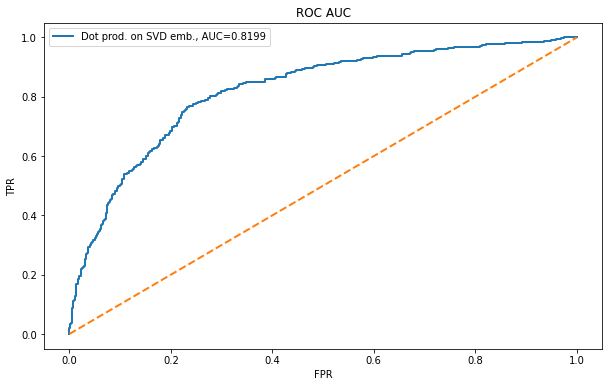

In [281]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, 
         label='{}, AUC={:.4f}'.format('Dot prod. on SVD emb.', auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 5. Classification on edge emdeddings (3 points)

Edge emeddings can be used for edge classification by any supervised algorithm (e.g. logistic regression). We can compute edge embeddings using embeddings of adjacent nodes. Let us compare several techniques of a such calculation from the paper: *Makarov I, Gerasimova O, Sulimov P, Zhukov LE. 2019. Dual network embedding for representing research interests in the link prediction problem on co-authorship networks*. Let us use SVD node embeddings for calculating edge embeddings.

In [282]:
G = nx.Graph()
G.add_nodes_from(range(np.max(train_pos) + 1))
G.add_edges_from(train_pos)
A = nx.to_numpy_array(G)
model = TruncatedSVD(n_components=4, random_state=0)
emb = model.fit_transform(A)
emb.round(2)

array([[ 0.77, -0.75, -0.46,  1.53],
       [ 0.04, -0.01, -0.04, -0.03],
       [ 1.83,  0.95,  0.24,  0.33],
       ...,
       [ 0.01, -0.  , -0.01, -0.01],
       [ 0.14, -0.05, -0.12, -0.06],
       [ 0.35, -0.3 , -0.37,  0.85]])

All following functions return edge embeddings for given graph, node embeddings, edges. Average operator is the elementwise average of node embeddings. 
$$
\frac{f(u)+f(v)}{2}
$$
where $f(u)$, $f(v)$ are node embeddings of nodes $u$ and $v$.

In [283]:
def average_operator(G, embeddings, edges):
    a = [] 
    for u, v in edges: 
        a.append((embeddings[u] + embeddings[v]) / 2) 
    return np.array(a)


In [284]:
assert np.allclose(
    average_operator(G, emb, np.array([[42,70]])).round(1),
    [[ 0.6, -0.2, -0.3, -0.2]]
)

Hadamard product is the elementwise product of node embeddings $$f(u) \odot f(v)$$

In [285]:
def hadamard_operator(G, embeddings, edges):
    a = [] 
    for u, v in edges: 
        a.append((embeddings[u] * embeddings[v])) 
    return np.array(a)

In [286]:
assert np.allclose(
    hadamard_operator(G, emb, np.array([[42,70]])).round(2),
    [[0.21, 0.02, 0.09, 0.02]]
)

Weighted L1 is the absolute elementwise difference between node embeddings $$
\left|f(u)-f(v)\right|
$$

In [287]:
def weighted_l1_operator(G, embeddings, edges):
    a = [] 
    for u, v in edges: 
        a.append(np.abs(embeddings[u] - embeddings[v])) 
    return np.array(a)

In [288]:
assert np.allclose(
    weighted_l1_operator(G, emb, np.array([[42,70]])).round(2),
    [[0.88, 0.12, 0.28, 0.17]]
)

Weighted L2 is the squared elementwise difference between node embeddings $$
\left(f(u)-f(v)\right)^{2}
$$

In [289]:
def weighted_l2_operator(G, embeddings, edges):
    a = [] 
    for u, v in edges: 
        a.append((embeddings[u] - embeddings[v]) ** 2) 
    return np.array(a)

In [290]:
assert np.allclose(
    weighted_l2_operator(G, emb, np.array([[42,70]])).round(2),
    [[0.77, 0.01, 0.08, 0.03]]
)

Neighbor weighted L1 is the absolute elementwise difference between mean embeddings of nodes neigbors $$
\left|\frac{\sum_{w \in N(u) \cup\{u\}} f(w)}{|N(u)|+1}-\frac{\sum_{t \in N(v) \cup\{v\}} f(t)}{|N(v)|+1}\right|
$$

In [291]:
def neighbor_weighted_l1_operator(G, embeddings, edges):
    a = [] 
    for u, v in edges: 
        ws = list(G.neighbors(u)) + [u]
        ts = list(G.neighbors(v)) + [v]
        res = np.abs(np.sum(embeddings[ws], axis=0) / len(ws)  - np.sum(embeddings[ts], axis=0) / len(ts)) 
        a.append(res)

    return np.array(a)

In [292]:
assert np.allclose(
    neighbor_weighted_l1_operator(G, emb, np.array([[42,70]])).round(2),
    [[1.89, 0.14, 0.3 , 0.18]]
)

Neighbor weighted L2 is the squared elementwise difference between mean embeddings of nodes neigbors
$$
\left(\frac{\sum_{w \in N(u) \cup\{u\}} f(w)}{|N(u)|+1}-\frac{\sum_{t \in N(v) \cup\{v\}} f(t)}{|N(v)|+1}\right)^{2}
$$

In [201]:
def neighbor_weighted_l2_operator(G, embeddings, edges):
    a = [] 
    for u, v in edges: 
        ws = list(G.neighbors(u)) + [u]
        ts = list(G.neighbors(v)) + [v]
        res = (np.sum(embeddings[ws], axis=0) / len(ws)  - np.sum(embeddings[ts], axis=0) / len(ts)) ** 2
        a.append(res)

    return np.array(a)

In [202]:
assert np.allclose(
    neighbor_weighted_l2_operator(G, emb, np.array([[42,70]])).round(2),
    [[3.58, 0.02, 0.09, 0.03]]
)

Now let us look at the ROC AUC for different operators on 16d SVD nome embeddings.

In [203]:
model = TruncatedSVD(n_components=16, random_state=0)
emb = model.fit_transform(A)

operators = {
    "Average": average_operator,
    "Hadamard product": hadamard_operator,
    "Weighted L1": weighted_l1_operator,
    "Weighted L2": weighted_l2_operator,
    "Neighbor weighted L1": neighbor_weighted_l1_operator,
    "Neighbor weighted L2": neighbor_weighted_l2_operator
}

res = dict()
for name, operator in operators.items():
    lr = LogisticRegression()
    train_emb = operator(G, emb, x_train)
    lr.fit(train_emb, y_train)
    test_emb = operator(G, emb, x_test)
    y_pred = lr.predict_proba(test_emb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    res[name] = {
        'fpr': fpr,
        'tpr': tpr
    }

assert auc(fpr, tpr) > 0.75

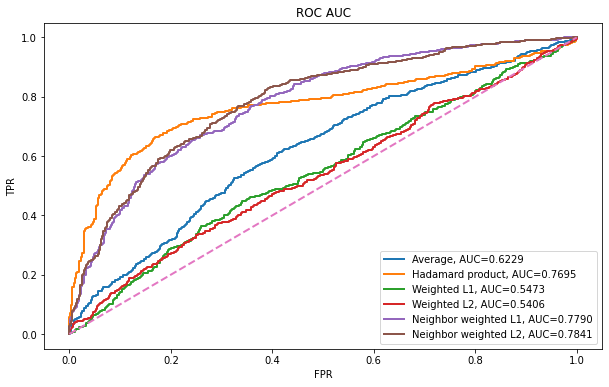

In [204]:
plt.figure(figsize=(10, 6))
for label, v in res.items():
    fpr, tpr = v['fpr'], v['tpr']
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### CORA dataset

In [14]:
# use for installation to colab/locally. Don't use it when upload to evalai

# !pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html -q 

     |████████████████████████████████| 4.9 MB 404 kB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 280 kB 9.1 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 103 kB 52.9 MB/s 
     |████████████████████████████████| 29.1 MB 1.3 MB/s 
     |████████████████████████████████| 109 kB 71.0 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 41 kB 211 kB/s 
     |████████████████████████████████| 3.2 MB 50.6 MB/s 
     |████████████████████████████████| 500 kB 38.7 MB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 67.9 MB/s 
     |████████████████████████████████| 90 kB 9.8 MB/s 
     |████████████████████████████████| 133 kB 75.5 MB/s 
     |████████████████████████████████| 121 kB 74.8 MB/s 
     |████████████████████████

In [15]:
import dgl
from dgl.data import CoraGraphDataset
from dgl import function as fn
from dgl.nn import SAGEConv

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [16]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 10556/2 links. Let us take a closer look at this dataset. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [17]:
data = CoraGraphDataset(force_reload=True)

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [18]:
graph = data[0]
graph

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})

Adjacency matrix can be obtained as follows

In [19]:
adj = graph.adj().to_dense()
adj

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

Feature matrix is stored in node features `feat`.

In [20]:
feat = graph.ndata['feat']
print(feat.shape)
feat

torch.Size([2708, 1433])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In DGL, Cora feature matrix are normalized so that the sum per row is 1. Labels are represent type of the publication, they are stored in `label`.

In [21]:
label = graph.ndata['label']
label

tensor([3, 4, 4,  ..., 3, 3, 3])

Here are train, validation and test masks.

In [22]:
train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
val_mask, train_mask, test_mask

(tensor([False, False, False,  ..., False, False, False]),
 tensor([ True,  True,  True,  ..., False, False, False]),
 tensor([False, False, False,  ...,  True,  True,  True]))

### Task 6. Graph convolution as matrix product (0 points)

Graph convolutional network (GCN) was proposed in [[1]](#references) and defined on an undirected graph as the following propagation rule:

$$H^{(l)}=\sigma\left(\tilde D^{-1 / 2} \tilde A \tilde D^{-1 / 2} H^{(l-1)} W^{(l)}\right)$$

where $\tilde A = A + I_N$ is the adjacency matrix with added self-connections. $I_N$ is the identity matrix, $\tilde D_{ii} = \sum_j \tilde A_{ij}$ is the degree matrix and $W^{(l)}$ is trainable matrix at the layer $l$. $\sigma$ represents non-linear activation function such as ReLU. $H^{(l)}$ is the hidden states at the layer $l$ and $H^{(0)} = X$ is the initial feature matrix.

Write a class `GCNMatrixProductLayer` that takes adjacency matrix, hidden states and returns the next hidden states before activation.

In [23]:
class GCNMatrixProductLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)
        
    def forward(self, adj, h):
        _adj = adj.clone()
        ### BEGIN SOLUTION
        _adj = _adj + np.eye(adj.shape[0], dtype='float32')
        norm = _adj.sum(dim=0)**-0.5
        _adj = norm[:, None] * _adj * norm[None, :]
        h = _adj @ self.dense(h)
        return h
        ### END SOLUTION

In [24]:
layer = GCNMatrixProductLayer(in_dim=2708, out_dim=10)
with torch.no_grad():
    layer.dense.weight.fill_(0.1)
    layer.dense.bias.fill_(0.1)
    h = layer(adj, torch.eye(2708))
assert round(h[0, 0].item(), 2) == 0.19

Write a class `GCNMatrixProduct` that takes the adjacency matrix and feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden and output dimensions.

In [25]:
class GCNMatrixProduct(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        ### BEGIN SOLUTION
        self.conv1 = GCNMatrixProductLayer(in_dim, hid_dim)
        self.conv2 = GCNMatrixProductLayer(hid_dim, out_dim)
        ### END SOLUTION
    def forward(self, adj, feat):
        ### BEGIN SOLUTION
        h = F.relu(self.conv1(adj, feat))
        h = self.conv2(adj, h)
        return h
        ### END SOLUTION

In [26]:
model = GCNMatrixProduct(2708, 32, 7)
logits = model(adj, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

Let us create the two-layer GCN for node classification task.

In [27]:
model = GCNMatrixProduct(1433, 32, 7)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

  0%|          | 0/200 [00:00<?, ?it/s]

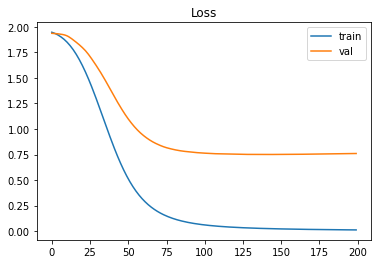

In [28]:
n_epochs = 200
for i in trange(n_epochs):
    
    logits = model(adj, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])
    
    log.append([train_loss.item(), val_loss.item()])
    
plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

We evaluate the model by balanced accuracy that accounts for inbalanced classes.

In [29]:
with torch.no_grad():
    logits = model(adj, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.81


### Task 7. Graph convolution as message passing (0 points)

The original GCN is computationally expensive for large graphs since it requires to compute matrix product $\tilde D^{-1 / 2} \tilde A \tilde D^{-1 / 2} H^{l}$, that costs $O(|V|^2)$. However, the information is propagated along edges, the number of which is linearly depends on the number of nodes in scale-free networks, that is $O(|V|)$. Message passing framework was proposed in [[2]](#references) to reduce computation costs by representing a graph neural network's layer as the composition of two functions:

$$m_{ij}^l = \text{Message}\left(h_i^{l-1}, h_j^{l-1}\right)$$
$$h_i^l = \text{Reduce}_{j \in \mathcal{N}_\text{in}(i)}\left(m_{ji}^l\right)$$

where $\text{Message}(\cdot)$ is the message function that applied on each edges in the graph and stores computed values (messages) on edges. $\text{Reduce}_{j \in \mathcal{N}_\text{in}(i)}(\cdot)$ is the reduce (aka aggregation, reduction) function that applied on each node and aggregates messages from incoming links (mailboxes). 

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/messpass.png' width=600>

In particular, GCN can be represented as follows:

$$h_i^l = \sigma \left(W^l \sum_{j \in \mathcal{N}_\text{in}(i)}\frac{h_j^{l-1}}{\sqrt{|\mathcal{N}_\text{in}(j)||\mathcal{N}_\text{in}(i)|}}\right)$$

where the message function

$$m_{ji}^l = \frac{W^l h_j^{l-1}}{\sqrt{|\mathcal{N}_\text{in}(j)|}}$$ 

is the transformed source node's hidden state normalized by the in-degree of the source node. The reduce function

$$h_i^l = \sigma \left(\frac{\sum_{j \in \mathcal{N}_\text{in}(i)} m_{ji}^l}{\sqrt{|\mathcal{N}_\text{in}(i)|}}\right)$$

is the sum over all incoming neighbors' hidden states with in-degree normalization and subsequent activation $\sigma$. Here we assume that the graph includes self-connections, that is a node is in its neighborhood. We also assume that the graph is equivalent to its undirected representation, that is $A = A^\top$.

In DGL, message passing is applied by `graph.update_all(message_func, reduce_func)` where `message_func` is defined on edges and `reduce_func` on nodes. DGL contains built-in message and reduce functions, but it is also possible to define your own functions. GCN can be implemented using following functions: 
* message function `fn.copy_src(src='h', out='m')` copies the source node feature `h` into the mailbox `m`
* reduce function `fn.sum(msg='m', out='h')` sums messages from mailboxes `m` and save the result into the node feature `h`

Write a class `GCNMessagePassingLayer` that takes a graph, hidden states and returns the next hidden states before activation.

*Hints:*
* _adding node features is similar to adding values to a dictionary: `graph.ndata['h'] = h`_
* _in-degrees can be computed by `graph.in_degrees()`_

*Remark: `graph.local_scope()` makes all operations isolated from the original graphs.*

In [37]:
class GCNMessagePassingLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)
    def forward(self, graph, h):
        with graph.local_scope():
            graph = graph.add_self_loop()
            ### BEGIN SOLUTION
            norm = graph.in_degrees()[:, None]**-0.5
            h = self.dense(h)
            h = h * norm
            graph.ndata['h'] = h
            graph.update_all(
                fn.copy_src(src='h', out='m'), 
                fn.sum(msg='m', out='h')
            )
            h = graph.ndata['h']
            h = h * norm
            return h
            ### END SOLUTION

In [38]:
layer = GCNMessagePassingLayer(in_dim=2708, out_dim=10)
with torch.no_grad():
    layer.dense.weight.fill_(0.1)
    layer.dense.bias.fill_(0.1)
    h = layer(graph, torch.eye(2708))
assert round(h[0, 0].item(), 2) == 0.19

Write a class `GCNMessagePassing` that takes the graph and feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden and output dimensions.

In [39]:
class GCNMessagePassing(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        ### BEGIN SOLUTION
        self.conv1 = GCNMessagePassingLayer(in_dim, hid_dim)
        self.conv2 = GCNMessagePassingLayer(hid_dim, out_dim)
        ### END SOLUTION
    def forward(self, graph, feat):
        ### BEGIN SOLUTION
        h = F.relu(self.conv1(graph, feat))
        h = self.conv2(graph, h)
        return h
        ### END SOLUTION

In [40]:
model = GCNMessagePassing(2708, 32, 7)
logits = model(graph, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

In [41]:
model = GCNMessagePassing(in_dim=1433, hid_dim=32, out_dim=7)
opt = Adam(model.parameters(), lr=0.01)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

  0%|          | 0/200 [00:00<?, ?it/s]

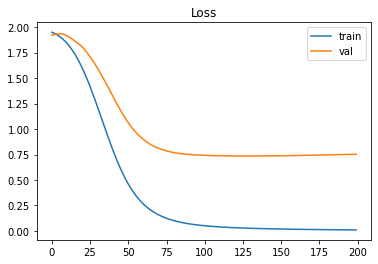

In [35]:
n_epochs = 200
for i in trange(n_epochs):
    
    logits = model(graph, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])
    
    log.append([train_loss.item(), val_loss.item()])
    
plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

In [36]:
with torch.no_grad():
    logits = model(graph, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.81


### Task 8. Graph auto-encoder (3 points)

Graph auto-encoder (GAE) was proposed in [[3]](#references) as a simple node embedding model that incorporates node features. The model consists of two parts:
* GCN node encoder $Z = \text{GCN}(X, A)$ where $X$ is the feature matrix
* Dot product decoder $\hat A = \sigma(ZZ^\top)$ where $\sigma$ is the sigmoid function

Write a class `DotProductDecoder` that takes node embeddgins and returns dot product before activation.

In [42]:
class DotProductDecoder(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, z):
        # YOUR CODE HERE
        return torch.mm(z, z.t())



In [43]:
decoder = DotProductDecoder()
assert torch.all(decoder(torch.eye(2)[:, :1]) * 2 == torch.tensor([[2, 0], [0, 0]]))

The GAE is trained to reconstruct the adjacency matrix, that is the decoder can be considered as the link prediction model. The reconstruction loss is the binary cross entropy between the adjacency matrix $A$ and reconstructed adjacency matrix $\hat A$. To overcome the imbalance between positive and negative edges, the loss is computed with positive weights — the number of negative examples divided by the number of positive examples, that is $(|V|^2 - E)/E$.

Write a class `ReconstructionLoss` that takes reconstructed adjacency matrix and computes the binary cross entropy with positive weights `F.binary_cross_entropy_with_logits(label, target, pos_weights=...)`. The class is initialized by the adjacency matrix.

In [44]:
class ReconstructionLoss:
    def __init__(self, adj):
        self.adj = adj

    def __call__(self, rec_adj):
        pos_weight = float(self.adj.shape[0] * self.adj.shape[0] - self.adj.sum()) / self.adj.sum()
        return F.binary_cross_entropy_with_logits(rec_adj, self.adj, pos_weight=pos_weight) 



In [45]:
rec_loss = ReconstructionLoss(torch.eye(2))
assert round(rec_loss(1 - torch.eye(2)).item(), 4) == 1.0032


Here we initialize encoder, decoder, reconstruction loss and optimizer.

In [319]:
encoder = GCNMessagePassing(in_dim=1433, hid_dim=64, out_dim=32)
decoder = DotProductDecoder()
rec_loss = ReconstructionLoss(adj)
opt = Adam(encoder.parameters(), lr=0.02)
log = []


Complete the training loop for GAE. Train the model in unsupervised setting: calculate the reconstruction loss over all edges.

  0%|          | 0/400 [00:00<?, ?it/s]

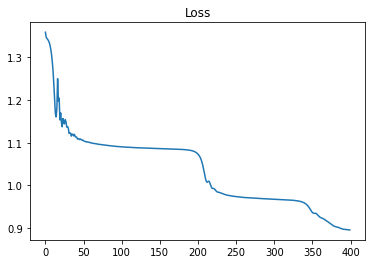

In [320]:
n_epochs = 400
for i in trange(n_epochs):
    ### BEGIN SOLUTION
    z = encoder(graph, feat)
    rec_adj = decoder(z)
    loss = rec_loss(rec_adj)

    opt.zero_grad()
    loss.backward()
    opt.step()

    log.append(loss.item())
    ### END SOLUTION
    
plt.plot(np.array(log))
plt.title('Loss')
plt.show()

We evaluate GAE by obtaining node embeddings via GCN encoder and training the logistic regression for node classification task.

In [321]:
with torch.no_grad():
    X = encoder.forward(graph, feat).numpy()
y = label.numpy()

lr = LogisticRegression()
lr.fit(X[train_mask], y[train_mask])

y_true = y[test_mask]
y_pred = lr.predict(X[test_mask])
score = balanced_accuracy_score(y_true, y_pred)
assert score >= 0.6
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.68


Let us visualize node embeddings via t-SNE.

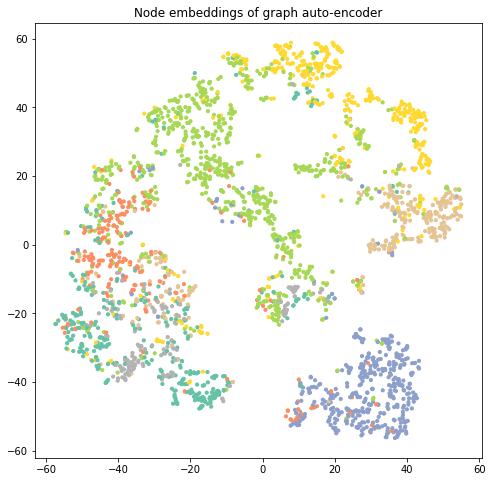

In [322]:
xy_emb = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(8, 8))
plt.title('Node embeddings of graph auto-encoder')
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=label, s=10, cmap=plt.cm.Set2)

Note that GAE is the simplest encoder-decoder graph model that can be extended to the variational graph auto-encoder (VGAE) [[3]](#references) and GraphVAE [[4]](#references).

### Task 9. Neighbor sampling with GraphSAGE (1 points)

GraphSAGE (SAmple and AggreGatE) was proposed in [[5]](#references) as a model for inductive representation learning on large graph. There are two main things:
* Neighbor sampling allows to train models in mini-batches, that is the model can be trained on large graphs and it also can represent previously unseen nodes (semi-supervised inductive learning)
* Aggregation is perfomed separately on neighboring nodes and the node itself, that can be considered as "skip-connections" in graph neural networks

Neighbor sampling is a technique to construct a message flow graph by randomly sampled neighbors of a target node.

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/neighbor_sampling.png' width=800>

In DGL, neighbor sampling is performed by `NodeDataLoader`. First, we create sets of indices with train, validation and test nodes.

In [46]:
train_nids = graph.nodes()[train_mask]
val_nids = graph.nodes()[val_mask]
test_nids = graph.nodes()[test_mask]
train_nids[:5], val_nids[:5], test_nids[:5]

(tensor([0, 1, 2, 3, 4]),
 tensor([140, 141, 142, 143, 144]),
 tensor([1708, 1709, 1710, 1711, 1712]))

Next, we create `NeighborSampler` with given number of neighbors for each layer of our network. Let it be 4 neihbors for the first layer and 4 neighbors for the second. Next, we create dataloader with the sampler.

In [47]:
sampler = dgl.dataloading.NeighborSampler(fanouts=[4, 4])
train_dataloader = dgl.dataloading.NodeDataLoader(graph, train_nids, sampler, batch_size=1)
len(train_dataloader)

140

We have set batch size is 1, that is each batch contains a single target node. The number of train nodes is 140. Dataloader iterates over:
* input nodes — the nodes from which we collect messages in the first layer
* output nodes — the target nodes that aggregate messages from neighbors in the second layers
* message flow graphs — list of graphs for layers

In [48]:
for input_nodes, output_nodes, mfgs in train_dataloader:
    break
input_nodes, output_nodes

(tensor([   0,  633, 1862, 2582, 1701, 1866,  926, 1166]), tensor([0]))

We see that the target node 0 aggregates messages from 0, 633, 1862, etc.

In [49]:
mfgs[1].edges()

(tensor([1, 2, 3]), tensor([0, 0, 0]))

The message flow graph (MFG) for the second layer consists of neighbors of the target nodes. Note that indices of nodes in MFG differs from indices in the original graph to optimize the message passing.

In [50]:
mfgs[1].srcnodes(), mfgs[1].dstnodes()

(tensor([0, 1, 2, 3]), tensor([0]))

MFG is bipartite, that is messages are passing from neighbors (source nodes) 0, 1, 2, 3 to the target (destination) node 0.

In [51]:
mfgs[0].edges()

(tensor([1, 2, 3, 0, 4, 5, 0, 6, 4, 3, 0, 7, 2]),
 tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3]))

The first MFG consists of edges that follow from source nodes in the first layer (0, 1, 2, 3, 4, 5, 6, 7) to sourse nodes in the second layer (0, 1, 2, 3). Let us create train, validation and test dataloaders with batch size 64.

In [52]:
train_dataloader = dgl.dataloading.NodeDataLoader(graph, train_nids, sampler, batch_size=64)
val_dataloader = dgl.dataloading.NodeDataLoader(graph, val_nids, sampler, batch_size=64)
test_dataloader = dgl.dataloading.NodeDataLoader(graph, test_nids, sampler, batch_size=64)
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(3, 8, 16)

GraphSAGE is defined by message passing:

$$h_i^l = W^l[h_i^{l-1} || \text{Aggregation}_{j \in \mathcal{N}(i)}(h_j^{l-1})]$$

where $[\cdot||\cdot]$ is concatenation. Aggregation function may be represented by average, maximum or LSTM. Let us define two-layer GraphSAGE with average aggregation and intermediate ReLU activation. `SAGEConv` layer takes the MFG and features of source node, returns the hidden of destinations nodes.

Write a function `forward` that takes MFGs, feature matrix for input nodes and returns the next hidden states of output nodes.

In [53]:
# To be deleted 

class GCNMessagePassing(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        ### BEGIN SOLUTION
        self.conv1 = GCNMessagePassingLayer(in_dim, hid_dim)
        self.conv2 = GCNMessagePassingLayer(hid_dim, out_dim)
        ### END SOLUTION
    def forward(self, graph, feat):
        ### BEGIN SOLUTION
        h = F.relu(self.conv1(graph, feat))
        h = self.conv2(graph, h)
        return h
        ### END SOLUTION


In [54]:
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hid_dim, aggregator_type='mean')
        self.conv2 = SAGEConv(hid_dim, out_dim, aggregator_type='mean')

    def forward(self, mfgs, feat):
        h = F.relu(self.conv1(mfgs, feat))
        h = self.conv2(mfgs, h)
        return h

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

Write a function `train_epoch` that takes GraphSAGE model, train dataloader, validation dataloader, the full feature matrix, labels and optimizer. It returns a tuple: the average train loss and the average validation loss. 

In [ ]:
model = GCNMessagePassing(in_dim=1433, hid_dim=32, out_dim=7)
opt = Adam(model.parameters(), lr=0.01)
log = []

n_epochs = 200
for i in trange(n_epochs):
    
    logits = model(graph, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])
    
    log.append([train_loss.item(), val_loss.item()])
    
plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()


In [83]:
def train_epoch(model, train_dataloader, val_dataloader, feat, label, opt):
    ### BEGIN SOLUTION
    train_losses = []
    for input_nodes, output_nodes, mfgs in train_dataloader:
        # YOUR CODE HERE
        print(feat[input_nodes])
        logits = model(mfgs, torch.tensor(feat))
        train_loss = F.cross_entropy(logits[train_mask], label[train_mask]) 
        # raise NotImplementedError()
        train_losses.append(train_loss.item())
    val_losses = []
    for input_nodes, output_nodes, mfgs in val_dataloader:
        with torch.no_grad():
            # YOUR CODE HERE
            val_loss = F.cross_entropy(logits[val_mask], label[val_mask])
            # raise NotImplementedError()
            val_losses.append(val_loss.item())
    return sum(train_losses) / len(train_losses), sum(val_losses) / len(val_losses)
    ### END SOLUTION

In [75]:
def train_epoch(model, train_dataloader, val_dataloader, feat, label, opt):
    ### BEGIN SOLUTION
    train_losses = []
    for input_nodes, output_nodes, mfgs in train_dataloader:
        # YOUR CODE HERE
        # train_loss
        # raise NotImplementedError()
        train_losses.append(train_loss.item())
    val_losses = []
    for input_nodes, output_nodes, mfgs in val_dataloader:
        with torch.no_grad():
            # YOUR CODE HERE
            # val_loss
            raise NotImplementedError()
            val_losses.append(val_loss.item())
    return sum(train_losses) / len(train_losses), sum(val_losses) / len(val_losses)
    ### END SOLUTION

In [84]:
model = GraphSAGE(1433, 16, 7)
opt = Adam(model.parameters(), lr=0.1)
train_loss, val_loss = train_epoch(model, train_dataloader, val_dataloader, feat, label, opt)
assert type(train_loss) == float
assert type(val_loss) == float
assert 1.8 < train_loss < 2.2
assert 1.8 < val_loss < 2.2
train_loss, val_loss = train_epoch(model, train_dataloader, val_dataloader, feat, label, opt)
train_loss, val_loss = train_epoch(model, train_dataloader, val_dataloader, feat, label, opt)
assert train_loss < val_loss

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


AttributeError: ignored

In [267]:
train_loss 

0.016191288828849792

In [268]:
val_loss 

0.7308991551399231

Initialize the model and optimizers.

In [ ]:
model = GraphSAGE(1433, 16, 7)
opt = Adam(model.parameters(), lr=0.01)

Train the model.

In [ ]:
log = []
n_epochs = 50
for i in trange(n_epochs):
    train_loss, val_loss = train_epoch(model, train_dataloader, val_dataloader, feat, label, opt)
    log.append([train_loss, val_loss])
plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

In [73]:
logits = []
for input_nodes, output_nodes, mfgs in test_dataloader:
    with torch.no_grad():
        logits.append(model(mfgs, feat[input_nodes]))
logits = torch.cat(logits)
y_pred = torch.argmax(logits, 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

AttributeError: ignored

### References

<a id='references'></a>

[1] Kipf, T. N., & Welling, M. (2016). Semi-Supervised Classification with Graph Convolutional Networks. CoRR, abs/1609.02907. http://arxiv.org/abs/1609.02907

[2] Gilmer, J., Schoenholz, S. S., Riley, P. F., Vinyals, O., & Dahl, G. E. (2017). Neural Message Passing for Quantum Chemistry. CoRR, abs/1704.01212. http://arxiv.org/abs/1704.01212

[3] Kipf, T. N., & Welling, M. (2016). Variational Graph Auto-Encoders. arXiv. https://doi.org/10.48550/ARXIV.1611.07308

[4] Simonovsky, M., & Komodakis, N. (2018). GraphVAE: Towards Generation of Small Graphs Using Variational Autoencoders. CoRR, abs/1802.03480. http://arxiv.org/abs/1802.03480

[5] Hamilton, W. L., Ying, R., & Leskovec, J. (2017). Inductive Representation Learning on Large Graphs. CoRR, abs/1706.02216. http://arxiv.org/abs/1706.02216